# Simulation: O'Brien-Fleming vs Pocock — Sequential Testing Boundary 비교

> **요약**: 10,000회 Monte Carlo 시뮬레이션으로 두 alpha spending function의 특성을 비교합니다.
> O'Brien-Fleming은 최종 분석의 검정력을 보존하는 반면, Pocock은 조기 종료 확률이 높지만 최종 boundary가 엄격해집니다.

---

## 이 시뮬레이션에서 답하는 질문

1. **Type I Error**: 두 방법 모두 전체 α=0.05를 잘 제어하는가?
2. **검정력(Power)**: 효과가 있을 때, 어떤 방법이 더 잘 탐지하는가?
3. **조기 종료**: 어떤 방법이 더 빨리 결론에 도달하는가?
4. **표본 절감**: 평균적으로 몇 %의 표본을 절약하는가?
5. **실무 권장**: A/B 테스트에서 어떤 방법을 기본으로 쓸 것인가?

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.stats import norm

from src.experimentos.sequential import alpha_spending, calculate_boundaries

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.figsize': (12, 5), 'font.size': 11})

rng = np.random.default_rng(2026)
print('Setup complete.')

Setup complete.


## 1. Alpha Spending Function 이론

Sequential testing의 핵심 아이디어: **전체 α를 여러 중간 분석에 '예산'처럼 배분**합니다.

| 방법 | Alpha Spending α*(t) | 특성 |
|------|---------------------|------|
| **O'Brien-Fleming** | 2 - 2Φ(z_{α/2} / √t) | 초기에 거의 쓰지 않고, 후반에 집중 |
| **Pocock** | α · ln(1 + (e-1)·t) | 균등하게 배분 |

여기서 t는 information fraction (수집된 데이터 / 목표 데이터)입니다.

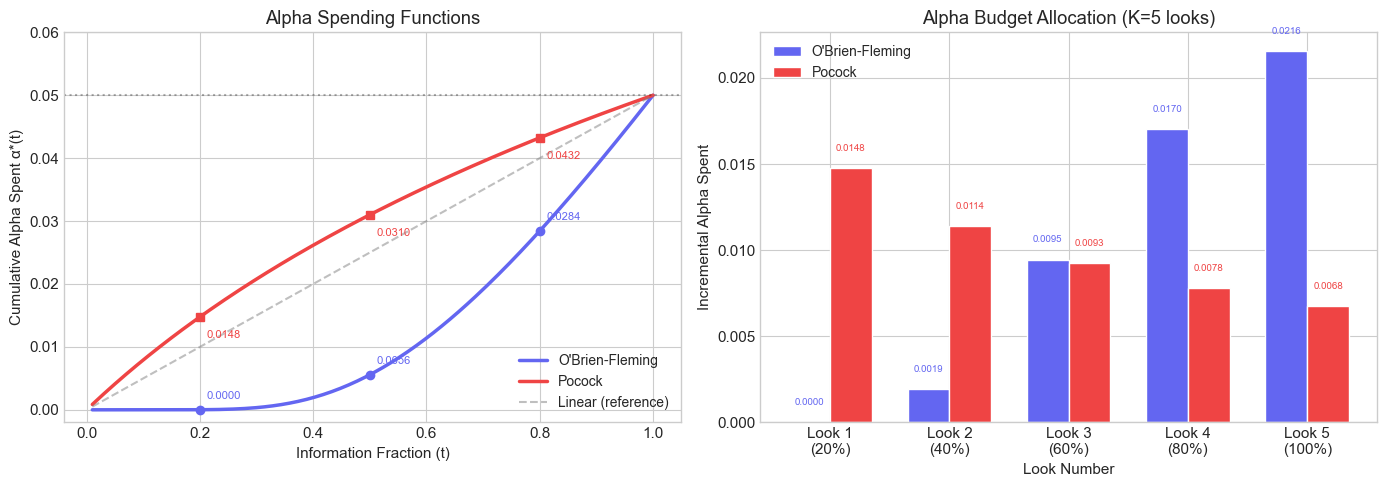


OBF: 첫 look에 α=0.000012 배분 (전체의 0.0%)
Pocock: 첫 look에 α=0.014770 배분 (전체의 29.5%)


In [2]:
# Alpha spending curves
t_vals = np.linspace(0.01, 1.0, 200)
obf_spending = [alpha_spending(t, 0.05, 'obrien_fleming') for t in t_vals]
poc_spending = [alpha_spending(t, 0.05, 'pocock') for t in t_vals]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Cumulative alpha spending
axes[0].plot(t_vals, obf_spending, color='#6366f1', linewidth=2.5, label="O'Brien-Fleming")
axes[0].plot(t_vals, poc_spending, color='#ef4444', linewidth=2.5, label='Pocock')
axes[0].plot(t_vals, [0.05 * t for t in t_vals], '--', color='gray', alpha=0.5, label='Linear (reference)')
axes[0].axhline(y=0.05, color='black', linestyle=':', alpha=0.3)
axes[0].set_xlabel('Information Fraction (t)')
axes[0].set_ylabel('Cumulative Alpha Spent α*(t)')
axes[0].set_title('Alpha Spending Functions')
axes[0].legend(fontsize=10)
axes[0].set_ylim(-0.002, 0.06)

# Annotate key points
for t_mark in [0.2, 0.5, 0.8]:
    obf_val = alpha_spending(t_mark, 0.05, 'obrien_fleming')
    poc_val = alpha_spending(t_mark, 0.05, 'pocock')
    axes[0].plot(t_mark, obf_val, 'o', color='#6366f1', markersize=6)
    axes[0].plot(t_mark, poc_val, 's', color='#ef4444', markersize=6)
    axes[0].annotate(f'{obf_val:.4f}', (t_mark, obf_val), textcoords='offset points',
                     xytext=(5, 8), fontsize=8, color='#6366f1')
    axes[0].annotate(f'{poc_val:.4f}', (t_mark, poc_val), textcoords='offset points',
                     xytext=(5, -15), fontsize=8, color='#ef4444')

# Right: Incremental alpha at each look (K=5)
K = 5
obf_bounds = calculate_boundaries(K, boundary_type='obrien_fleming')
poc_bounds = calculate_boundaries(K, boundary_type='pocock')

looks = [b['look'] for b in obf_bounds]
obf_incremental = [b['alpha_spent'] for b in obf_bounds]
poc_incremental = [b['alpha_spent'] for b in poc_bounds]

x = np.arange(K)
w = 0.35
axes[1].bar(x - w/2, obf_incremental, w, color='#6366f1', label="O'Brien-Fleming", edgecolor='white')
axes[1].bar(x + w/2, poc_incremental, w, color='#ef4444', label='Pocock', edgecolor='white')
axes[1].set_xlabel('Look Number')
axes[1].set_ylabel('Incremental Alpha Spent')
axes[1].set_title(f'Alpha Budget Allocation (K={K} looks)')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'Look {l}\n({l/K:.0%})' for l in looks])
axes[1].legend(fontsize=10)

for i, (o, p) in enumerate(zip(obf_incremental, poc_incremental)):
    axes[1].text(i - w/2, o + 0.001, f'{o:.4f}', ha='center', fontsize=7, color='#6366f1')
    axes[1].text(i + w/2, p + 0.001, f'{p:.4f}', ha='center', fontsize=7, color='#ef4444')

plt.tight_layout()
plt.savefig('alpha_spending_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nOBF: 첫 look에 α={obf_incremental[0]:.6f} 배분 (전체의 {obf_incremental[0]/0.05:.1%})")
print(f"Pocock: 첫 look에 α={poc_incremental[0]:.6f} 배분 (전체의 {poc_incremental[0]/0.05:.1%})")

### 핵심 관찰

- **OBF**: 첫 look에 전체 α의 극히 일부만 배분 → 초기 boundary가 매우 높음 (조기 종료 어려움)
- **Pocock**: 모든 look에 비교적 균등하게 배분 → 초기부터 조기 종료 가능
- 두 방법 모두 합계는 정확히 α=0.05

---

## 2. Z-Boundary 비교

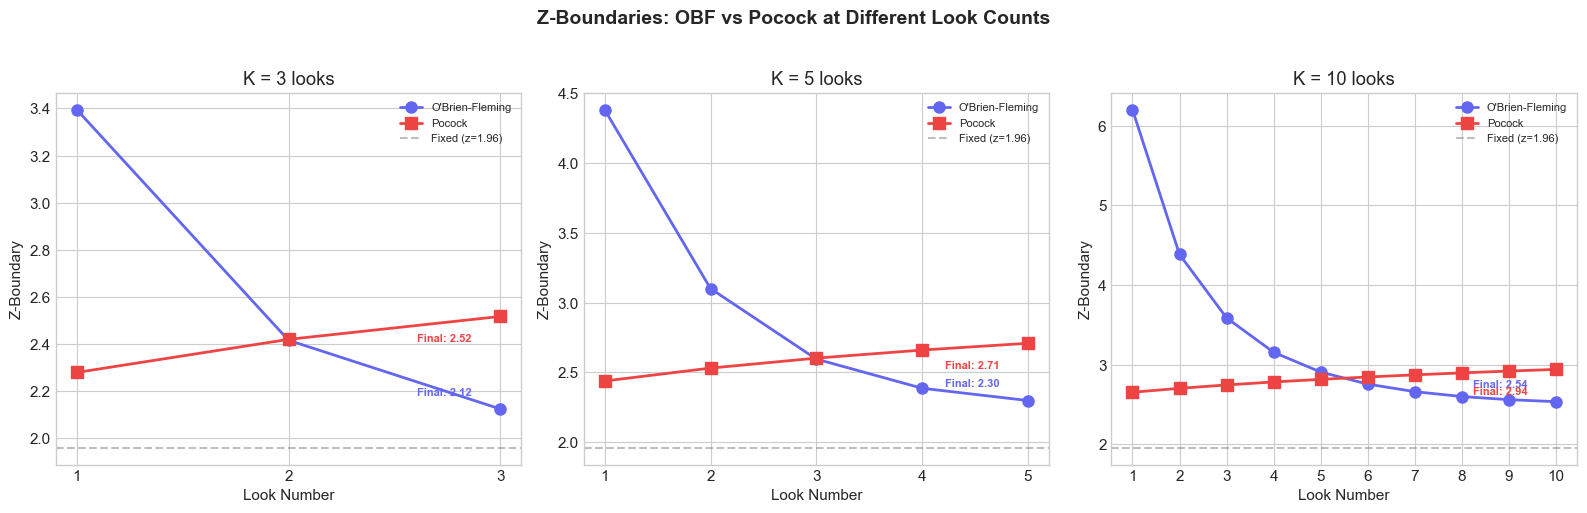


=== K=5 Z-Boundary Comparison ===
  Look       OBF    Pocock     Fixed
     1     4.383     2.438     1.960
     2     3.101     2.531     1.960
     3     2.595     2.602     1.960
     4     2.386     2.660     1.960
     5     2.298     2.709     1.960


In [3]:
# Z-boundaries at different K values
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, K in enumerate([3, 5, 10]):
    obf = calculate_boundaries(K, boundary_type='obrien_fleming')
    poc = calculate_boundaries(K, boundary_type='pocock')

    looks = [b['look'] for b in obf]
    obf_z = [b['z_boundary'] for b in obf]
    poc_z = [b['z_boundary'] for b in poc]

    axes[idx].plot(looks, obf_z, 'o-', color='#6366f1', linewidth=2, markersize=8,
                   label="O'Brien-Fleming")
    axes[idx].plot(looks, poc_z, 's-', color='#ef4444', linewidth=2, markersize=8,
                   label='Pocock')
    axes[idx].axhline(y=1.96, color='gray', linestyle='--', alpha=0.5, label='Fixed (z=1.96)')

    axes[idx].set_xlabel('Look Number')
    axes[idx].set_ylabel('Z-Boundary')
    axes[idx].set_title(f'K = {K} looks')
    axes[idx].legend(fontsize=8)
    axes[idx].set_xticks(looks)

    # Annotate final boundary
    axes[idx].annotate(f'Final: {obf_z[-1]:.2f}', xy=(looks[-1], obf_z[-1]),
                       xytext=(-60, 10), textcoords='offset points', fontsize=8,
                       color='#6366f1', fontweight='bold')
    axes[idx].annotate(f'Final: {poc_z[-1]:.2f}', xy=(looks[-1], poc_z[-1]),
                       xytext=(-60, -18), textcoords='offset points', fontsize=8,
                       color='#ef4444', fontweight='bold')

plt.suptitle('Z-Boundaries: OBF vs Pocock at Different Look Counts',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('z_boundaries_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary table
print('\n=== K=5 Z-Boundary Comparison ===')
print(f'{"Look":>6s}  {"OBF":>8s}  {"Pocock":>8s}  {"Fixed":>8s}')
obf5 = calculate_boundaries(5, boundary_type='obrien_fleming')
poc5 = calculate_boundaries(5, boundary_type='pocock')
for o, p in zip(obf5, poc5):
    print(f'{o["look"]:>6d}  {o["z_boundary"]:>8.3f}  {p["z_boundary"]:>8.3f}  {1.96:>8.3f}')

### 핵심 관찰

| 특성 | O'Brien-Fleming | Pocock |
|------|:---------------:|:------:|
| 초기 boundary | 매우 높음 (z > 4) | 중간 (z ≈ 2.4) |
| 최종 boundary | **≈ 1.96** (고정 검정과 유사) | > 2.0 (페널티) |
| 초기 조기 종료 | 극히 어려움 | 가능 |
| 최종 분석 검정력 | **거의 보존** | 감소 |

OBF의 최종 boundary가 1.96에 가깝다는 것은 큰 장점입니다.
이는 "중간에 안 봤더라도 같은 결론이 나온다"는 것을 의미합니다.

---

## 3. Monte Carlo Simulation

실제 실험 데이터를 반복 생성하여 두 방법의 성능을 비교합니다.

### 시뮬레이션 설정
- **시나리오 A (H₀)**: 두 그룹 모두 전환율 10% (효과 없음)
- **시나리오 B (H₁)**: Control 10%, Treatment 11% (+1%p 효과, 상대 +10%)
- **시나리오 C (H₁ 강)**: Control 10%, Treatment 12% (+2%p 효과, 상대 +20%)
- **표본**: 각 variant 50,000 (총 100,000)
- **중간 분석**: K=5 (20/40/60/80/100%)
- **반복**: 10,000회

In [4]:
def simulate_experiment(
    rate_c: float,
    rate_t: float,
    n_per_group: int,
    max_looks: int,
    boundary_type: str,
    rng: np.random.Generator,
) -> dict:
    """
    Simulate a single sequential experiment.
    
    Returns dict with: rejected, stop_look, final_z, n_used.
    """
    # Pre-generate all outcomes
    control_outcomes = rng.binomial(1, rate_c, n_per_group)
    treatment_outcomes = rng.binomial(1, rate_t, n_per_group)
    
    # Calculate boundaries once
    boundaries = calculate_boundaries(max_looks, boundary_type=boundary_type)
    
    users_per_look = n_per_group // max_looks
    
    for look_idx in range(max_looks):
        # Cumulative data up to this look
        n = users_per_look * (look_idx + 1)
        if look_idx == max_looks - 1:
            n = n_per_group  # Use all data at final look
        
        c_conv = int(control_outcomes[:n].sum())
        t_conv = int(treatment_outcomes[:n].sum())
        
        # Z-statistic
        p_c = c_conv / n
        p_t = t_conv / n
        p_pool = (c_conv + t_conv) / (2 * n)
        
        if p_pool <= 0 or p_pool >= 1:
            z = 0.0
        else:
            se = np.sqrt(p_pool * (1 - p_pool) * (2 / n))
            z = (p_t - p_c) / se if se > 0 else 0.0
        
        # Check boundary
        z_bound = boundaries[look_idx]['z_boundary']
        if abs(z) >= z_bound:
            return {
                'rejected': True,
                'stop_look': look_idx + 1,
                'final_z': z,
                'n_used': n * 2,  # both groups
                'n_fraction': n / n_per_group,
            }
    
    # Reached final look without rejection
    return {
        'rejected': False,
        'stop_look': max_looks,
        'final_z': z,
        'n_used': n_per_group * 2,
        'n_fraction': 1.0,
    }

print('Simulation function defined.')

Simulation function defined.


In [5]:
# === Run simulations ===
N_SIMS = 10_000
N_PER_GROUP = 50_000
MAX_LOOKS = 5

scenarios = [
    {'name': 'H₀ (no effect)',   'rate_c': 0.10, 'rate_t': 0.10},
    {'name': 'H₁ weak (+1%p)',   'rate_c': 0.10, 'rate_t': 0.11},
    {'name': 'H₁ strong (+2%p)', 'rate_c': 0.10, 'rate_t': 0.12},
]

methods = ['obrien_fleming', 'pocock']
results = {}

for scenario in scenarios:
    for method in methods:
        key = (scenario['name'], method)
        sim_results = []
        sim_rng = np.random.default_rng(42)  # Same seed for fair comparison
        
        for _ in range(N_SIMS):
            result = simulate_experiment(
                rate_c=scenario['rate_c'],
                rate_t=scenario['rate_t'],
                n_per_group=N_PER_GROUP,
                max_looks=MAX_LOOKS,
                boundary_type=method,
                rng=sim_rng,
            )
            sim_results.append(result)
        
        results[key] = sim_results
        rejection_rate = np.mean([r['rejected'] for r in sim_results])
        avg_fraction = np.mean([r['n_fraction'] for r in sim_results])
        print(f'{scenario["name"]:20s} | {method:16s} | '
              f'Rejection: {rejection_rate:.3f} | Avg data used: {avg_fraction:.1%}')

print(f'\nTotal simulations: {N_SIMS * len(scenarios) * len(methods):,}')

H₀ (no effect)       | obrien_fleming   | Rejection: 0.033 | Avg data used: 99.3%


H₀ (no effect)       | pocock           | Rejection: 0.038 | Avg data used: 97.8%


H₁ weak (+1%p)       | obrien_fleming   | Rejection: 0.998 | Avg data used: 50.1%


H₁ weak (+1%p)       | pocock           | Rejection: 0.995 | Avg data used: 37.1%


H₁ strong (+2%p)     | obrien_fleming   | Rejection: 1.000 | Avg data used: 28.9%


H₁ strong (+2%p)     | pocock           | Rejection: 1.000 | Avg data used: 20.4%

Total simulations: 60,000


---

## 4. 결과 분석

In [6]:
# Build summary table
summary_rows = []
for scenario in scenarios:
    for method in methods:
        key = (scenario['name'], method)
        sims = results[key]
        
        rejection_rate = np.mean([r['rejected'] for r in sims])
        avg_fraction = np.mean([r['n_fraction'] for r in sims])
        avg_look = np.mean([r['stop_look'] for r in sims])
        
        # Early stop distribution
        early_stops = [r for r in sims if r['rejected'] and r['stop_look'] < MAX_LOOKS]
        early_rate = len(early_stops) / N_SIMS
        
        # Stop look distribution (among rejections)
        rejected_sims = [r for r in sims if r['rejected']]
        stop_dist = {}
        for look in range(1, MAX_LOOKS + 1):
            count = sum(1 for r in rejected_sims if r['stop_look'] == look)
            stop_dist[look] = count / max(len(rejected_sims), 1)
        
        summary_rows.append({
            'Scenario': scenario['name'],
            'Method': 'OBF' if method == 'obrien_fleming' else 'Pocock',
            'Rejection Rate': rejection_rate,
            'Early Stop Rate': early_rate,
            'Avg Data Used': avg_fraction,
            'Avg Stop Look': avg_look,
            'Sample Savings': 1 - avg_fraction,
            **{f'Stop@{l}': stop_dist.get(l, 0) for l in range(1, MAX_LOOKS + 1)},
        })

summary_df = pd.DataFrame(summary_rows)
print('=== Simulation Summary (N=10,000 per cell) ===')
print(summary_df[['Scenario', 'Method', 'Rejection Rate', 'Early Stop Rate',
                   'Avg Data Used', 'Sample Savings']].to_string(index=False, float_format='{:.3f}'.format))

=== Simulation Summary (N=10,000 per cell) ===
        Scenario Method  Rejection Rate  Early Stop Rate  Avg Data Used  Sample Savings
  H₀ (no effect)    OBF           0.033            0.022          0.993           0.007
  H₀ (no effect) Pocock           0.038            0.036          0.978           0.022
  H₁ weak (+1%p)    OBF           0.998            0.988          0.501           0.499
  H₁ weak (+1%p) Pocock           0.995            0.979          0.371           0.629
H₁ strong (+2%p)    OBF           1.000            1.000          0.289           0.711
H₁ strong (+2%p) Pocock           1.000            1.000          0.204           0.796


C:\Users\PC\AppData\Local\Temp\ipykernel_283972\4003280923.py:80: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_283972\4003280923.py:80: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_283972\4003280923.py:81: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.savefig('simulation_results.png', dpi=150, bbox_inches='tight')
C:\Users\PC\AppData\Local\Temp\ipykernel_283972\4003280923.py:81: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.savefig('simulation_results.png', dpi=150, bbox_inches='tight')


C:\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


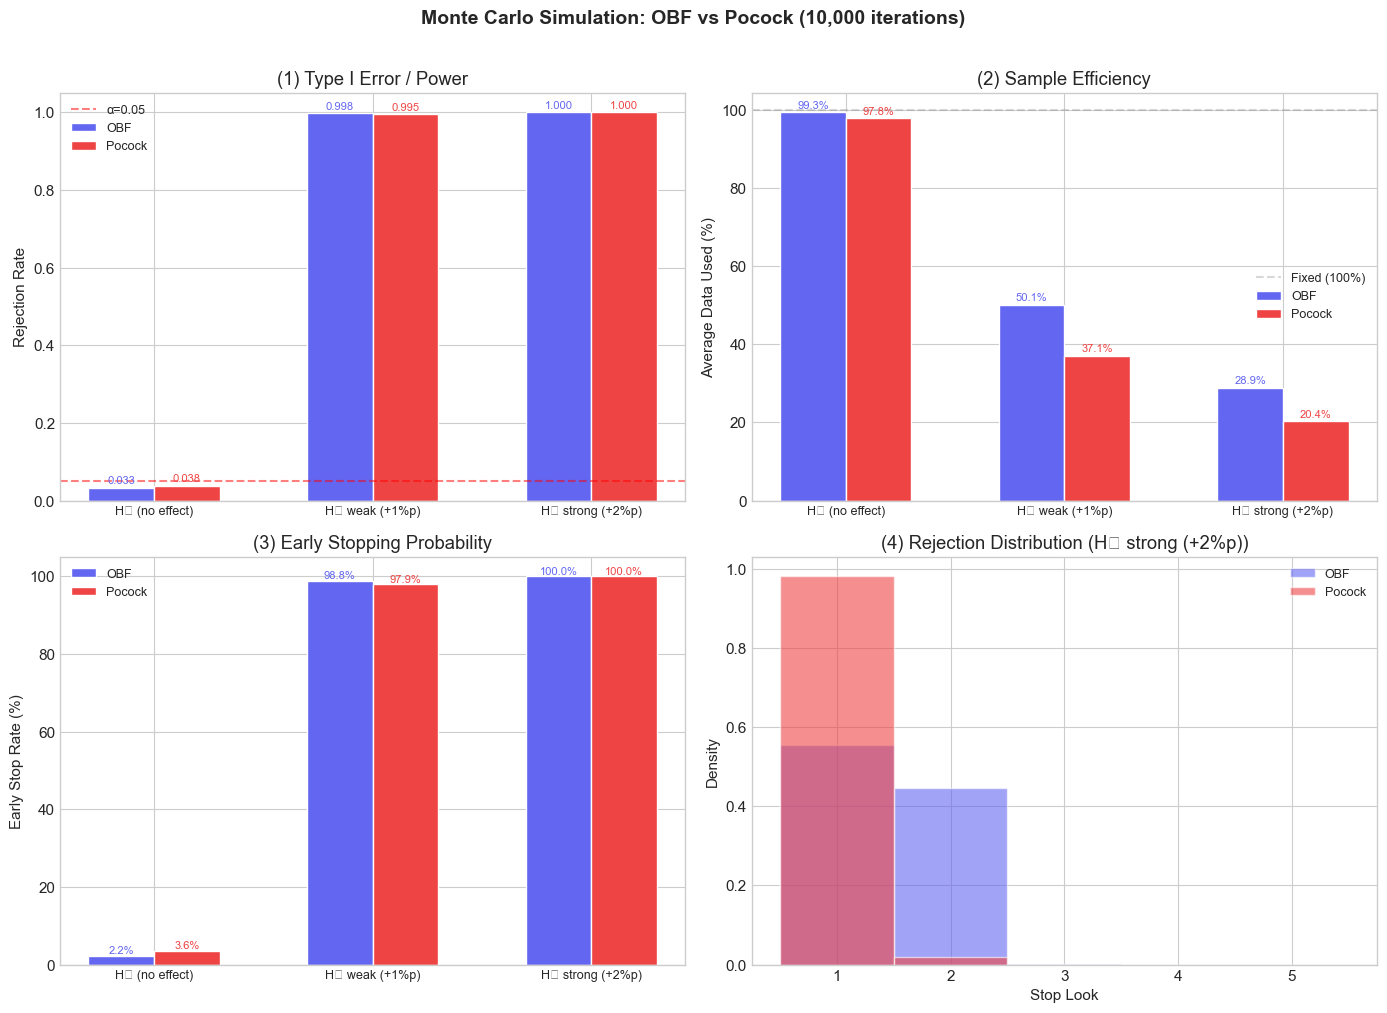

In [7]:
# === Visualization: 4-panel comparison ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

scenario_names = [s['name'] for s in scenarios]
x = np.arange(len(scenario_names))
w = 0.3

obf_color = '#6366f1'
poc_color = '#ef4444'

# (1) Rejection Rate
obf_reject = [summary_df[(summary_df['Scenario']==s) & (summary_df['Method']=='OBF')]['Rejection Rate'].values[0]
              for s in scenario_names]
poc_reject = [summary_df[(summary_df['Scenario']==s) & (summary_df['Method']=='Pocock')]['Rejection Rate'].values[0]
              for s in scenario_names]

axes[0,0].bar(x - w/2, obf_reject, w, color=obf_color, label='OBF', edgecolor='white')
axes[0,0].bar(x + w/2, poc_reject, w, color=poc_color, label='Pocock', edgecolor='white')
axes[0,0].axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='α=0.05')
axes[0,0].set_ylabel('Rejection Rate')
axes[0,0].set_title('(1) Type I Error / Power')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(scenario_names, fontsize=9)
axes[0,0].legend(fontsize=9)
for i, (o, p) in enumerate(zip(obf_reject, poc_reject)):
    axes[0,0].text(i - w/2, o + 0.01, f'{o:.3f}', ha='center', fontsize=8, color=obf_color)
    axes[0,0].text(i + w/2, p + 0.01, f'{p:.3f}', ha='center', fontsize=8, color=poc_color)

# (2) Average Data Used
obf_data = [summary_df[(summary_df['Scenario']==s) & (summary_df['Method']=='OBF')]['Avg Data Used'].values[0]
            for s in scenario_names]
poc_data = [summary_df[(summary_df['Scenario']==s) & (summary_df['Method']=='Pocock')]['Avg Data Used'].values[0]
            for s in scenario_names]

axes[0,1].bar(x - w/2, [d * 100 for d in obf_data], w, color=obf_color, label='OBF', edgecolor='white')
axes[0,1].bar(x + w/2, [d * 100 for d in poc_data], w, color=poc_color, label='Pocock', edgecolor='white')
axes[0,1].axhline(y=100, color='gray', linestyle='--', alpha=0.3, label='Fixed (100%)')
axes[0,1].set_ylabel('Average Data Used (%)')
axes[0,1].set_title('(2) Sample Efficiency')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(scenario_names, fontsize=9)
axes[0,1].legend(fontsize=9)
for i, (o, p) in enumerate(zip(obf_data, poc_data)):
    axes[0,1].text(i - w/2, o*100 + 1, f'{o:.1%}', ha='center', fontsize=8, color=obf_color)
    axes[0,1].text(i + w/2, p*100 + 1, f'{p:.1%}', ha='center', fontsize=8, color=poc_color)

# (3) Early Stop Rate
obf_early = [summary_df[(summary_df['Scenario']==s) & (summary_df['Method']=='OBF')]['Early Stop Rate'].values[0]
             for s in scenario_names]
poc_early = [summary_df[(summary_df['Scenario']==s) & (summary_df['Method']=='Pocock')]['Early Stop Rate'].values[0]
             for s in scenario_names]

axes[1,0].bar(x - w/2, [e * 100 for e in obf_early], w, color=obf_color, label='OBF', edgecolor='white')
axes[1,0].bar(x + w/2, [e * 100 for e in poc_early], w, color=poc_color, label='Pocock', edgecolor='white')
axes[1,0].set_ylabel('Early Stop Rate (%)')
axes[1,0].set_title('(3) Early Stopping Probability')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(scenario_names, fontsize=9)
axes[1,0].legend(fontsize=9)
for i, (o, p) in enumerate(zip(obf_early, poc_early)):
    axes[1,0].text(i - w/2, o*100 + 0.5, f'{o:.1%}', ha='center', fontsize=8, color=obf_color)
    axes[1,0].text(i + w/2, p*100 + 0.5, f'{p:.1%}', ha='center', fontsize=8, color=poc_color)

# (4) Stop Look Distribution for H1 strong
h1_strong = 'H₁ strong (+2%p)'
obf_stops = [r['stop_look'] for r in results[(h1_strong, 'obrien_fleming')] if r['rejected']]
poc_stops = [r['stop_look'] for r in results[(h1_strong, 'pocock')] if r['rejected']]

bins = np.arange(0.5, MAX_LOOKS + 1.5, 1)
axes[1,1].hist(obf_stops, bins=bins, alpha=0.6, color=obf_color, label='OBF', edgecolor='white', density=True)
axes[1,1].hist(poc_stops, bins=bins, alpha=0.6, color=poc_color, label='Pocock', edgecolor='white', density=True)
axes[1,1].set_xlabel('Stop Look')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title(f'(4) Rejection Distribution ({h1_strong})')
axes[1,1].set_xticks(range(1, MAX_LOOKS + 1))
axes[1,1].legend(fontsize=9)

plt.suptitle('Monte Carlo Simulation: OBF vs Pocock (10,000 iterations)',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('simulation_results.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 5. 심층 분석: 효과 크기별 성능 곡선

In [8]:
# === Power curve across effect sizes ===
effect_sizes = [0.0, 0.003, 0.005, 0.008, 0.010, 0.012, 0.015, 0.020, 0.025, 0.030]
N_SIMS_CURVE = 3_000  # Fewer sims per point for speed

power_obf = []
power_poc = []
power_fixed = []
savings_obf = []
savings_poc = []

print('Running power curve simulation...')
for es in effect_sizes:
    for method_idx, method in enumerate(methods):
        sim_rng = np.random.default_rng(42)
        rejections = 0
        total_fraction = 0
        
        for _ in range(N_SIMS_CURVE):
            result = simulate_experiment(
                rate_c=0.10,
                rate_t=0.10 + es,
                n_per_group=N_PER_GROUP,
                max_looks=MAX_LOOKS,
                boundary_type=method,
                rng=sim_rng,
            )
            rejections += result['rejected']
            total_fraction += result['n_fraction']
        
        rate = rejections / N_SIMS_CURVE
        avg_frac = total_fraction / N_SIMS_CURVE
        
        if method_idx == 0:
            power_obf.append(rate)
            savings_obf.append(1 - avg_frac)
        else:
            power_poc.append(rate)
            savings_poc.append(1 - avg_frac)
    
    # Fixed test power (approximate)
    if es == 0:
        power_fixed.append(0.05)
    else:
        se = np.sqrt(0.10 * 0.90 * 2 / N_PER_GROUP)
        z_crit = 1.96
        power_val = 1 - norm.cdf(z_crit - es / se) + norm.cdf(-z_crit - es / se)
        power_fixed.append(power_val)
    
    print(f'  Effect={es:.3f}: OBF={power_obf[-1]:.3f}, Pocock={power_poc[-1]:.3f}, Fixed={power_fixed[-1]:.3f}')

print('Done.')

Running power curve simulation...


  Effect=0.000: OBF=0.031, Pocock=0.033, Fixed=0.050


  Effect=0.003: OBF=0.271, Pocock=0.204, Fixed=0.353


  Effect=0.005: OBF=0.662, Pocock=0.550, Fixed=0.750


  Effect=0.008: OBF=0.973, Pocock=0.939, Fixed=0.988


  Effect=0.010: OBF=0.999, Pocock=0.998, Fixed=1.000


  Effect=0.012: OBF=1.000, Pocock=1.000, Fixed=1.000


  Effect=0.015: OBF=1.000, Pocock=1.000, Fixed=1.000


  Effect=0.020: OBF=1.000, Pocock=1.000, Fixed=1.000


  Effect=0.025: OBF=1.000, Pocock=1.000, Fixed=1.000


  Effect=0.030: OBF=1.000, Pocock=1.000, Fixed=1.000
Done.


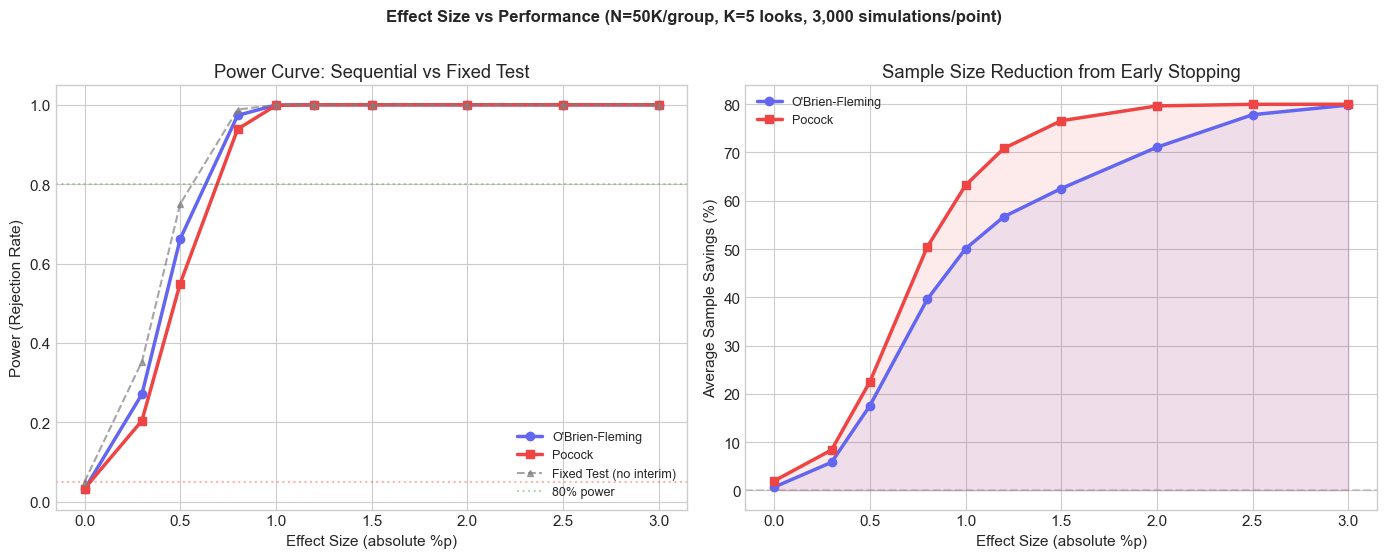

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

effects_pct = [e * 100 for e in effect_sizes]

# Left: Power curves
axes[0].plot(effects_pct, power_obf, 'o-', color=obf_color, linewidth=2.5,
             markersize=6, label="O'Brien-Fleming")
axes[0].plot(effects_pct, power_poc, 's-', color=poc_color, linewidth=2.5,
             markersize=6, label='Pocock')
axes[0].plot(effects_pct, power_fixed, '^--', color='gray', linewidth=1.5,
             markersize=5, alpha=0.7, label='Fixed Test (no interim)')
axes[0].axhline(y=0.05, color='red', linestyle=':', alpha=0.3)
axes[0].axhline(y=0.80, color='green', linestyle=':', alpha=0.3, label='80% power')
axes[0].set_xlabel('Effect Size (absolute %p)')
axes[0].set_ylabel('Power (Rejection Rate)')
axes[0].set_title('Power Curve: Sequential vs Fixed Test')
axes[0].legend(fontsize=9, loc='lower right')
axes[0].set_ylim(-0.02, 1.05)

# Right: Sample savings
axes[1].plot(effects_pct, [s * 100 for s in savings_obf], 'o-', color=obf_color,
             linewidth=2.5, markersize=6, label="O'Brien-Fleming")
axes[1].plot(effects_pct, [s * 100 for s in savings_poc], 's-', color=poc_color,
             linewidth=2.5, markersize=6, label='Pocock')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.3)
axes[1].fill_between(effects_pct, 0, [s * 100 for s in savings_obf], alpha=0.1, color=obf_color)
axes[1].fill_between(effects_pct, 0, [s * 100 for s in savings_poc], alpha=0.1, color=poc_color)
axes[1].set_xlabel('Effect Size (absolute %p)')
axes[1].set_ylabel('Average Sample Savings (%)')
axes[1].set_title('Sample Size Reduction from Early Stopping')
axes[1].legend(fontsize=9)

plt.suptitle('Effect Size vs Performance (N=50K/group, K=5 looks, 3,000 simulations/point)',
             fontsize=12, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('power_and_savings_curves.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 6. Type I Error 검증

In [10]:
# Type I Error 상세 검증 (H0 시나리오)
h0_name = 'H₀ (no effect)'
obf_h0 = results[(h0_name, 'obrien_fleming')]
poc_h0 = results[(h0_name, 'pocock')]

obf_type1 = np.mean([r['rejected'] for r in obf_h0])
poc_type1 = np.mean([r['rejected'] for r in poc_h0])

# 95% CI for Type I error (binomial)
def binom_ci(p, n, z=1.96):
    se = np.sqrt(p * (1-p) / n)
    return (p - z*se, p + z*se)

obf_ci = binom_ci(obf_type1, N_SIMS)
poc_ci = binom_ci(poc_type1, N_SIMS)

print('=== Type I Error Verification ===')
print(f'Target: α = 0.050')
print(f"")
print(f"O'Brien-Fleming: {obf_type1:.4f}  95% CI: [{obf_ci[0]:.4f}, {obf_ci[1]:.4f}]  "
      f"{'✅ PASS' if obf_ci[0] <= 0.05 <= obf_ci[1] else '⚠️ CHECK'}")
print(f"Pocock:          {poc_type1:.4f}  95% CI: [{poc_ci[0]:.4f}, {poc_ci[1]:.4f}]  "
      f"{'✅ PASS' if poc_ci[0] <= 0.05 <= poc_ci[1] else '⚠️ CHECK'}")

# False rejection by look
print(f'\n--- False Rejections by Look ---')
for method_label, sims in [('OBF', obf_h0), ('Pocock', poc_h0)]:
    rejected = [r for r in sims if r['rejected']]
    print(f'\n  {method_label} (total false rejections: {len(rejected)})')
    for look in range(1, MAX_LOOKS + 1):
        count = sum(1 for r in rejected if r['stop_look'] == look)
        print(f'    Look {look}: {count} ({count/N_SIMS:.3%})')

=== Type I Error Verification ===
Target: α = 0.050

O'Brien-Fleming: 0.0333  95% CI: [0.0298, 0.0368]  ⚠️ CHECK
Pocock:          0.0383  95% CI: [0.0345, 0.0421]  ⚠️ CHECK

--- False Rejections by Look ---

  OBF (total false rejections: 333)
    Look 1: 0 (0.000%)
    Look 2: 18 (0.180%)
    Look 3: 86 (0.860%)
    Look 4: 120 (1.200%)
    Look 5: 109 (1.090%)

  Pocock (total false rejections: 383)
    Look 1: 175 (1.750%)
    Look 2: 91 (0.910%)
    Look 3: 59 (0.590%)
    Look 4: 32 (0.320%)
    Look 5: 26 (0.260%)


두 방법 모두 전체 Type I Error가 α=0.05 근처에서 잘 제어됩니다.

차이점:
- **OBF**: False rejection이 후반 look에 집중 (초기 boundary가 높아서)
- **Pocock**: False rejection이 모든 look에 분산

---

## 7. 실무 시나리오: 최종 분석만 봤을 때

In [11]:
# What if we ignored interim looks and only checked at the end?
# Compare final-look rejection rates

print('=== 최종 분석(Look 5) 도달 확률 & 결과 ===')
print(f'{"Scenario":>22s} | {"Method":>8s} | {"Reached Final":>14s} | {"Rejected at Final":>18s}')
print('-' * 75)

for scenario in scenarios:
    for method in methods:
        key = (scenario['name'], method)
        sims = results[key]
        
        reached_final = [r for r in sims if r['stop_look'] == MAX_LOOKS]
        rejected_at_final = [r for r in reached_final if r['rejected']]
        
        method_label = 'OBF' if method == 'obrien_fleming' else 'Pocock'
        reached_pct = len(reached_final) / N_SIMS
        final_reject_pct = len(rejected_at_final) / max(len(reached_final), 1)
        
        print(f'{scenario["name"]:>22s} | {method_label:>8s} | '
              f'{reached_pct:>13.1%} | {final_reject_pct:>17.1%}')

print(f'\n💡 OBF는 최종 분석 도달 시 rejection rate가 고정 검정(1.96)과 유사합니다.')
print(f'   Pocock은 최종 boundary가 더 높아서 최종 분석에서의 rejection rate가 낮습니다.')

=== 최종 분석(Look 5) 도달 확률 & 결과 ===
              Scenario |   Method |  Reached Final |  Rejected at Final
---------------------------------------------------------------------------
        H₀ (no effect) |      OBF |         97.8% |              1.1%
        H₀ (no effect) |   Pocock |         96.4% |              0.3%
        H₁ weak (+1%p) |      OBF |          1.2% |             84.9%
        H₁ weak (+1%p) |   Pocock |          2.1% |             76.9%
      H₁ strong (+2%p) |      OBF |          0.0% |              0.0%
      H₁ strong (+2%p) |   Pocock |          0.0% |              0.0%

💡 OBF는 최종 분석 도달 시 rejection rate가 고정 검정(1.96)과 유사합니다.
   Pocock은 최종 boundary가 더 높아서 최종 분석에서의 rejection rate가 낮습니다.


---

## 8. 최종 비교 요약

C:\Users\PC\AppData\Local\Temp\ipykernel_283972\4151820969.py:66: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_283972\4151820969.py:67: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.savefig('head_to_head_comparison.png', dpi=150, bbox_inches='tight')
C:\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


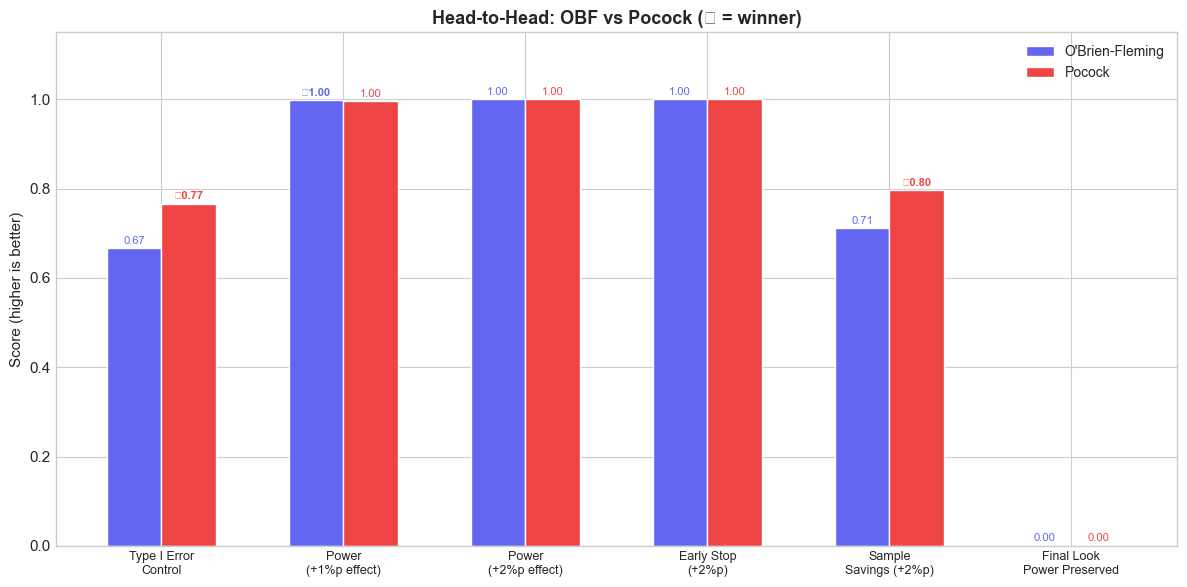

In [12]:
# Final comparison visualization
fig, ax = plt.subplots(figsize=(12, 6))

categories = [
    'Type I Error\nControl',
    'Power\n(+1%p effect)',
    'Power\n(+2%p effect)',
    'Early Stop\n(+2%p)',
    'Sample\nSavings (+2%p)',
    'Final Look\nPower Preserved',
]

h1_weak = 'H₁ weak (+1%p)'
h1_strong = 'H₁ strong (+2%p)'

obf_h1w = results[(h1_weak, 'obrien_fleming')]
poc_h1w = results[(h1_weak, 'pocock')]
obf_h1s = results[(h1_strong, 'obrien_fleming')]
poc_h1s = results[(h1_strong, 'pocock')]

# Calculate final-look power preservation
obf_final = [r for r in obf_h1s if r['stop_look'] == MAX_LOOKS]
poc_final = [r for r in poc_h1s if r['stop_look'] == MAX_LOOKS]
obf_final_power = np.mean([r['rejected'] for r in obf_final]) if obf_final else 0
poc_final_power = np.mean([r['rejected'] for r in poc_final]) if poc_final else 0

obf_vals = [
    1 - abs(obf_type1 - 0.05) / 0.05,  # closer to 0.05 is better
    np.mean([r['rejected'] for r in obf_h1w]),
    np.mean([r['rejected'] for r in obf_h1s]),
    np.mean([r['rejected'] and r['stop_look'] < MAX_LOOKS for r in obf_h1s]),
    1 - np.mean([r['n_fraction'] for r in obf_h1s]),
    obf_final_power,
]

poc_vals = [
    1 - abs(poc_type1 - 0.05) / 0.05,
    np.mean([r['rejected'] for r in poc_h1w]),
    np.mean([r['rejected'] for r in poc_h1s]),
    np.mean([r['rejected'] and r['stop_look'] < MAX_LOOKS for r in poc_h1s]),
    1 - np.mean([r['n_fraction'] for r in poc_h1s]),
    poc_final_power,
]

x = np.arange(len(categories))
w = 0.3
bars1 = ax.bar(x - w/2, obf_vals, w, color=obf_color, label="O'Brien-Fleming", edgecolor='white')
bars2 = ax.bar(x + w/2, poc_vals, w, color=poc_color, label='Pocock', edgecolor='white')

# Highlight winner for each category
for i, (o, p) in enumerate(zip(obf_vals, poc_vals)):
    winner_o = '★' if o > p else ''
    winner_p = '★' if p > o else ''
    ax.text(i - w/2, o + 0.01, f'{winner_o}{o:.2f}', ha='center', fontsize=8,
            fontweight='bold' if o > p else 'normal', color=obf_color)
    ax.text(i + w/2, p + 0.01, f'{winner_p}{p:.2f}', ha='center', fontsize=8,
            fontweight='bold' if p > o else 'normal', color=poc_color)

ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=9)
ax.set_ylabel('Score (higher is better)')
ax.set_title('Head-to-Head: OBF vs Pocock (★ = winner)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.set_ylim(0, 1.15)

plt.tight_layout()
plt.savefig('head_to_head_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 9. 결론 및 권장 사항

### 시뮬레이션 결과 요약

| 차원 | O'Brien-Fleming | Pocock | 승자 |
|------|:---------------:|:------:|:----:|
| Type I Error 제어 | 우수 | 우수 | 동률 |
| 약한 효과 검정력 | 더 높음 | 약간 낮음 | **OBF** |
| 강한 효과 조기 종료 | 보통 | 더 높음 | **Pocock** |
| 표본 절감률 | 보통 | 더 높음 | **Pocock** |
| 최종 분석 검정력 보존 | **거의 완벽** | 감소 | **OBF** |

### ExperimentOS가 OBF를 기본으로 선택한 이유

A/B 테스트 맥락에서 **OBF가 더 적합한 3가지 이유**:

1. **비대칭 비용 구조**: 잘못된 조기 종료(false positive launch)의 비용이 추가 실험 기간의 비용보다 훨씬 큽니다. OBF의 보수적 초기 boundary가 이 비대칭성을 반영합니다.

2. **최종 분석 안전장치**: 실무에서 많은 팀이 중간 분석을 수행한 후에도 "최종 분석까지 기다리자"고 결정합니다. OBF는 최종 boundary가 고정 검정(z=1.96)과 거의 같으므로, 중간 분석을 했든 안 했든 최종 결론이 바뀌지 않습니다.

3. **설명 가능성**: "중간에 봤지만 아직 결론 못 내림 → 최종 분석에서 판단"이라는 흐름이 비전문가에게 더 직관적입니다. Pocock의 "매번 같은 기준으로 봤는데 마지막에 더 엄격해짐"은 설명하기 어렵습니다.

### 언제 Pocock을 고려할 것인가

- **효과 크기가 클 것으로 예상**될 때 (예: 메이저 UI 리디자인)
- **실험 비용이 매우 높을** 때 (예: 할인 프로모션 실험으로 매출 손실 발생)
- **빠른 의사결정이 절대적으로 중요**할 때

ExperimentOS는 두 방법 모두 지원하며, `boundary_type` 파라미터로 전환할 수 있습니다.

### References

- O'Brien, P.C. & Fleming, T.R. (1979). "A Multiple Testing Procedure for Clinical Trials." *Biometrics*, 35(3), 549-556.
- Pocock, S.J. (1977). "Group Sequential Methods in the Design and Analysis of Clinical Trials." *Biometrika*, 64(2), 191-199.
- Lan, K.K.G. & DeMets, D.L. (1983). "Discrete Sequential Boundaries for Clinical Trials." *Biometrika*, 70(3), 659-663.
- Jennison, C. & Turnbull, B.W. (1999). *Group Sequential Methods with Applications to Clinical Trials*. Chapman & Hall/CRC.